In [1]:
# AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=25
n_units=512
l2Regularizer=1e-09
kernel_size1 = 2
kernel_size2 = 5
n_grid = 101
strides = 2
input_size = 49
dropout_rate = 0.5

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out')

In [7]:
origin = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin_data)
folders = [file for file in folders_orig if file.startswith('airfoil')]

In [9]:
coord_df = pd.DataFrame()
counter = 1
for i in range(1, 134):
    coord_file_name = origin_coord + "\\airfoil" + str(i) + "\\airfoilOut"+ str(i) + ".txt"
    data = pd.read_csv(coord_file_name, sep = ",", header=None)
    while counter < 17:
        coord_df = pd.concat([coord_df, data], axis=0)
        counter += 1
    counter=1

In [10]:
coord_np = coord_df.iloc[:, :].values

In [11]:
coord = coord_np.reshape((len(folders), 16, 2, 50))

In [12]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [13]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [14]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [15]:
y = y.reshape((133, 16, 2, 1))

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [17]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [18]:
geometry.shape

(2128, 1)

In [19]:
geometry = geometry.reshape((133, 16, 1))

In [20]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(coord, aa, geometry, y, test_size=0.3, random_state=1)

In [21]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [22]:
input_coord = tf.keras.Input(shape=(2, 50, 1))
input_alpha = tf.keras.Input(shape=(1,1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer')(input_coord)
x_ = tf.keras.layers.MaxPooling2D((1,2))(x_conv)
reshape1 = tf.keras.layers.Flatten()(x_)
reshape2 = tf.keras.layers.Reshape((1,))(input_alpha)
x_concat = tf.keras.layers.Concatenate(axis=1)([reshape1, reshape2])

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_concat)
x_ = tf.keras.layers.Dropout(dropout_rate)(x_)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)
x_ = tf.keras.layers.Dropout(dropout_rate)(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayerSensor')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-I
model = tf.keras.Model([input_coord, input_alpha], output_image)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 50, 1)]   0           []                               
                                                                                                  
 Conv2DLayer (Conv2D)           (None, 1, 25, 25)    275         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 12, 25)    0           ['Conv2DLayer[0][0]']            
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                              

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
start = datetime.datetime.now()
history = model.fit([x_train,aa_train], y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
47/47 [==============================] - 4s 8ms/step - loss: 0.4846 - rmse: 0.6961
Epoch 2/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.1037 - rmse: 0.3220
Epoch 3/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0752 - rmse: 0.2742
Epoch 4/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0610 - rmse: 0.2471
Epoch 5/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0502 - rmse: 0.2241
Epoch 6/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0462 - rmse: 0.2150
Epoch 7/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0434 - rmse: 0.2083
Epoch 8/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0401 - rmse: 0.2003
Epoch 9/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0390 - rmse: 0.1974
Epoch 10/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0360 - rmse: 0.1897
Epoch 11/5000
47/47 [==================

47/47 [==============================] - 0s 7ms/step - loss: 0.0196 - rmse: 0.1401
Epoch 86/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0181 - rmse: 0.1346
Epoch 87/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0194 - rmse: 0.1393
Epoch 88/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0199 - rmse: 0.1411
Epoch 89/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0172 - rmse: 0.1312
Epoch 90/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0181 - rmse: 0.1344
Epoch 91/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0179 - rmse: 0.1339
Epoch 92/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0184 - rmse: 0.1356
Epoch 93/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0170 - rmse: 0.1303
Epoch 94/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0175 - rmse: 0.1322
Epoch 95/5000
47/47 [=======================

47/47 [==============================] - 0s 7ms/step - loss: 0.0156 - rmse: 0.1249
Epoch 169/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0163 - rmse: 0.1278
Epoch 170/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0163 - rmse: 0.1277
Epoch 171/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0155 - rmse: 0.1244
Epoch 172/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0161 - rmse: 0.1270
Epoch 173/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0162 - rmse: 0.1273
Epoch 174/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0164 - rmse: 0.1282
Epoch 175/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0161 - rmse: 0.1269
Epoch 176/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0160 - rmse: 0.1265
Epoch 177/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0160 - rmse: 0.1265
Epoch 178/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0152 - rmse: 0.1233
Epoch 252/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0152 - rmse: 0.1235
Epoch 253/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0155 - rmse: 0.1246
Epoch 254/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0147 - rmse: 0.1211
Epoch 255/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0150 - rmse: 0.1224
Epoch 256/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0156 - rmse: 0.1248
Epoch 257/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0145 - rmse: 0.1202
Epoch 258/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0155 - rmse: 0.1247
Epoch 259/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0157 - rmse: 0.1252
Epoch 260/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0149 - rmse: 0.1221
Epoch 261/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1193
Epoch 335/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0146 - rmse: 0.1208
Epoch 336/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0158 - rmse: 0.1256
Epoch 337/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0149 - rmse: 0.1222
Epoch 338/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0141 - rmse: 0.1189
Epoch 339/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0147 - rmse: 0.1213
Epoch 340/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0143 - rmse: 0.1195
Epoch 341/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0151 - rmse: 0.1229
Epoch 342/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1192
Epoch 343/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0145 - rmse: 0.1205
Epoch 344/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1176
Epoch 418/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1156
Epoch 419/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0143 - rmse: 0.1197
Epoch 420/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0144 - rmse: 0.1202
Epoch 421/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0144 - rmse: 0.1199
Epoch 422/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0145 - rmse: 0.1202
Epoch 423/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1150
Epoch 424/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0146 - rmse: 0.1208
Epoch 425/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1193
Epoch 426/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1191
Epoch 427/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0150 - rmse: 0.1226
Epoch 501/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0148 - rmse: 0.1217
Epoch 502/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0145 - rmse: 0.1205
Epoch 503/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0143 - rmse: 0.1197
Epoch 504/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1146
Epoch 505/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0143 - rmse: 0.1195
Epoch 506/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0144 - rmse: 0.1198
Epoch 507/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0147 - rmse: 0.1214
Epoch 508/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0148 - rmse: 0.1215
Epoch 509/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1172
Epoch 510/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0153 - rmse: 0.1236
Epoch 584/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1174
Epoch 585/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1177
Epoch 586/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0143 - rmse: 0.1194
Epoch 587/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0146 - rmse: 0.1209
Epoch 588/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0144 - rmse: 0.1200
Epoch 589/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0139 - rmse: 0.1180
Epoch 590/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1150
Epoch 591/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1173
Epoch 592/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1192
Epoch 593/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0146 - rmse: 0.1206
Epoch 667/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1151
Epoch 668/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1190
Epoch 669/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1194
Epoch 670/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1165
Epoch 671/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0144 - rmse: 0.1201
Epoch 672/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0145 - rmse: 0.1204
Epoch 673/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1192
Epoch 674/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1160
Epoch 675/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0149 - rmse: 0.1222
Epoch 676/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1155
Epoch 750/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0145 - rmse: 0.1204
Epoch 751/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0143 - rmse: 0.1195
Epoch 752/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1190
Epoch 753/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1164
Epoch 754/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1193
Epoch 755/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0144 - rmse: 0.1198
Epoch 756/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0149 - rmse: 0.1221
Epoch 757/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1191
Epoch 758/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 759/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1168
Epoch 833/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0140 - rmse: 0.1184
Epoch 834/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1154
Epoch 835/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0139 - rmse: 0.1178
Epoch 836/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0140 - rmse: 0.1185
Epoch 837/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0154 - rmse: 0.1239
Epoch 838/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1136
Epoch 839/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1190
Epoch 840/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1193
Epoch 841/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1175
Epoch 842/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1170
Epoch 916/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 917/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0146 - rmse: 0.1207
Epoch 918/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1142
Epoch 919/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1147
Epoch 920/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0141 - rmse: 0.1185
Epoch 921/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 922/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0144 - rmse: 0.1198
Epoch 923/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1167
Epoch 924/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1170
Epoch 925/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0141 - rmse: 0.1187
Epoch 999/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1162
Epoch 1000/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1150
Epoch 1001/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1190
Epoch 1002/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1153
Epoch 1003/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1162
Epoch 1004/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1149
Epoch 1005/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0143 - rmse: 0.1194
Epoch 1006/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0140 - rmse: 0.1184
Epoch 1007/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1160
Epoch 1008/5000
47/47 [====

47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1168
Epoch 1081/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0139 - rmse: 0.1178
Epoch 1082/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1144
Epoch 1083/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0140 - rmse: 0.1182
Epoch 1084/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1152
Epoch 1085/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1159
Epoch 1086/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0141 - rmse: 0.1189
Epoch 1087/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1159
Epoch 1088/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1137
Epoch 1089/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1148
Epoch 1090/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1152
Epoch 1163/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1135
Epoch 1164/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1149
Epoch 1165/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1130
Epoch 1166/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1170
Epoch 1167/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0141 - rmse: 0.1188
Epoch 1168/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1149
Epoch 1169/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1174
Epoch 1170/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1165
Epoch 1171/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1141
Epoch 1172/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0144 - rmse: 0.1199
Epoch 1245/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1144
Epoch 1246/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1133
Epoch 1247/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1154
Epoch 1248/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1158
Epoch 1249/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1151
Epoch 1250/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1149
Epoch 1251/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1149
Epoch 1252/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1141
Epoch 1253/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1118
Epoch 1254/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0143 - rmse: 0.1197
Epoch 1327/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1146
Epoch 1328/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1152
Epoch 1329/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1121
Epoch 1330/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1166
Epoch 1331/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1147
Epoch 1332/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1136
Epoch 1333/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1139
Epoch 1334/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1141
Epoch 1335/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1152
Epoch 1336/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1109
Epoch 1409/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1125
Epoch 1410/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1119
Epoch 1411/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1154
Epoch 1412/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1131
Epoch 1413/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1159
Epoch 1414/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1155
Epoch 1415/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1123
Epoch 1416/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1131
Epoch 1417/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1135
Epoch 1418/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1100
Epoch 1491/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 1492/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 1493/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1135
Epoch 1494/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1122
Epoch 1495/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 1496/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1147
Epoch 1497/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0143 - rmse: 0.1195
Epoch 1498/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1095
Epoch 1499/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1150
Epoch 1500/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1176
Epoch 1573/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1174
Epoch 1574/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1171
Epoch 1575/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0147 - rmse: 0.1214
Epoch 1576/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1156
Epoch 1577/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1141
Epoch 1578/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1121
Epoch 1579/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1149
Epoch 1580/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1175
Epoch 1581/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0147 - rmse: 0.1212
Epoch 1582/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1146
Epoch 1655/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 1656/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1167
Epoch 1657/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0137 - rmse: 0.1169
Epoch 1658/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0134 - rmse: 0.1156
Epoch 1659/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 1660/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0128 - rmse: 0.1133
Epoch 1661/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0138 - rmse: 0.1174
Epoch 1662/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1136
Epoch 1663/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1148
Epoch 1664/5000
47/47 [===

47/47 [==============================] - 0s 8ms/step - loss: 0.0127 - rmse: 0.1129
Epoch 1737/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0139 - rmse: 0.1178
Epoch 1738/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0133 - rmse: 0.1153
Epoch 1739/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0139 - rmse: 0.1178
Epoch 1740/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0137 - rmse: 0.1169
Epoch 1741/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 1742/5000
47/47 [==============================] - 0s 9ms/step - loss: 0.0140 - rmse: 0.1184
Epoch 1743/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0124 - rmse: 0.1112
Epoch 1744/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0137 - rmse: 0.1170
Epoch 1745/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0130 - rmse: 0.1142
Epoch 1746/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1102
Epoch 1819/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1171
Epoch 1820/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1168
Epoch 1821/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 1822/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1148
Epoch 1823/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1108
Epoch 1824/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1146
Epoch 1825/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1116
Epoch 1826/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1138
Epoch 1827/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0139 - rmse: 0.1179
Epoch 1828/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1130
Epoch 1901/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1146
Epoch 1902/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0133 - rmse: 0.1155
Epoch 1903/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0127 - rmse: 0.1128
Epoch 1904/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0134 - rmse: 0.1158
Epoch 1905/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1144
Epoch 1906/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1144
Epoch 1907/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0143 - rmse: 0.1197
Epoch 1908/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1151
Epoch 1909/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1144
Epoch 1910/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1126
Epoch 1983/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1156
Epoch 1984/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1151
Epoch 1985/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1133
Epoch 1986/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0141 - rmse: 0.1187
Epoch 1987/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1174
Epoch 1988/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1126
Epoch 1989/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1151
Epoch 1990/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1122
Epoch 1991/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1098
Epoch 1992/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1123
Epoch 2065/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1155
Epoch 2066/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 2067/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0141 - rmse: 0.1186
Epoch 2068/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1152
Epoch 2069/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1119
Epoch 2070/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0141 - rmse: 0.1187
Epoch 2071/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1115
Epoch 2072/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1119
Epoch 2073/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0117 - rmse: 0.1082
Epoch 2074/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - rmse: 0.1092
Epoch 2147/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1167
Epoch 2148/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1150
Epoch 2149/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 2150/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - rmse: 0.1089
Epoch 2151/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1129
Epoch 2152/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1169
Epoch 2153/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1115
Epoch 2154/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1150
Epoch 2155/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1125
Epoch 2156/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1145
Epoch 2229/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1162
Epoch 2230/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1162
Epoch 2231/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1137
Epoch 2232/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1122
Epoch 2233/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1132
Epoch 2234/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1116
Epoch 2235/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1118
Epoch 2236/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1128
Epoch 2237/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1138
Epoch 2238/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1173
Epoch 2311/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1129
Epoch 2312/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1125
Epoch 2313/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1162
Epoch 2314/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1192
Epoch 2315/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1167
Epoch 2316/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1113
Epoch 2317/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1164
Epoch 2318/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1127
Epoch 2319/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1097
Epoch 2320/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1191
Epoch 2393/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1131
Epoch 2394/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1107
Epoch 2395/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1116
Epoch 2396/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1153
Epoch 2397/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1137
Epoch 2398/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1143
Epoch 2399/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1114
Epoch 2400/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1132
Epoch 2401/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0125 - rmse: 0.1120
Epoch 2402/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1125
Epoch 2475/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1120
Epoch 2476/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - rmse: 0.1089
Epoch 2477/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0122 - rmse: 0.1106
Epoch 2478/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1153
Epoch 2479/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1097
Epoch 2480/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1152
Epoch 2481/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1121
Epoch 2482/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 2483/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1147
Epoch 2484/5000
47/47 [===

47/47 [==============================] - 0s 8ms/step - loss: 0.0138 - rmse: 0.1173
Epoch 2557/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1153
Epoch 2558/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1103
Epoch 2559/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0117 - rmse: 0.1082
Epoch 2560/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0121 - rmse: 0.1101
Epoch 2561/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0131 - rmse: 0.1146
Epoch 2562/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0121 - rmse: 0.1100
Epoch 2563/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1127
Epoch 2564/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0121 - rmse: 0.1101
Epoch 2565/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0136 - rmse: 0.1165
Epoch 2566/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1101
Epoch 2639/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1104
Epoch 2640/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1114
Epoch 2641/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1142
Epoch 2642/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0139 - rmse: 0.1178
Epoch 2643/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1133
Epoch 2644/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1130
Epoch 2645/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1101
Epoch 2646/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1131
Epoch 2647/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1120
Epoch 2648/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1173
Epoch 2721/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1157
Epoch 2722/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1131
Epoch 2723/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1106
Epoch 2724/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1107
Epoch 2725/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1127
Epoch 2726/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1100
Epoch 2727/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1142
Epoch 2728/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1139
Epoch 2729/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1158
Epoch 2730/5000
47/47 [===

47/47 [==============================] - 0s 8ms/step - loss: 0.0124 - rmse: 0.1112
Epoch 2803/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0122 - rmse: 0.1103
Epoch 2804/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1135
Epoch 2805/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1149
Epoch 2806/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1115
Epoch 2807/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1147
Epoch 2808/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0126 - rmse: 0.1124
Epoch 2809/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1134
Epoch 2810/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1118
Epoch 2811/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1154
Epoch 2812/5000
47/47 [===

47/47 [==============================] - 0s 8ms/step - loss: 0.0138 - rmse: 0.1172
Epoch 2885/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0137 - rmse: 0.1172
Epoch 2886/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1134
Epoch 2887/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1102
Epoch 2888/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0121 - rmse: 0.1099
Epoch 2889/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1122
Epoch 2890/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1127
Epoch 2891/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1171
Epoch 2892/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1128
Epoch 2893/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1140
Epoch 2894/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1110
Epoch 2967/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1106
Epoch 2968/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0139 - rmse: 0.1178
Epoch 2969/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0123 - rmse: 0.1108
Epoch 2970/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0126 - rmse: 0.1122
Epoch 2971/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0127 - rmse: 0.1126
Epoch 2972/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0120 - rmse: 0.1093
Epoch 2973/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0131 - rmse: 0.1145
Epoch 2974/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0128 - rmse: 0.1132
Epoch 2975/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0125 - rmse: 0.1116
Epoch 2976/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1140
Epoch 3049/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0118 - rmse: 0.1087
Epoch 3050/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0139 - rmse: 0.1178
Epoch 3051/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1154
Epoch 3052/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1144
Epoch 3053/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1124
Epoch 3054/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1121
Epoch 3055/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1149
Epoch 3056/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1137
Epoch 3057/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1159
Epoch 3058/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1103
Epoch 3131/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1106
Epoch 3132/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1145
Epoch 3133/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1156
Epoch 3134/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1140
Epoch 3135/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1165
Epoch 3136/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1126
Epoch 3137/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1119
Epoch 3138/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1122
Epoch 3139/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1144
Epoch 3140/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1125
Epoch 3213/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1110
Epoch 3214/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1136
Epoch 3215/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 3216/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - rmse: 0.1091
Epoch 3217/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1102
Epoch 3218/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1128
Epoch 3219/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1111
Epoch 3220/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1094
Epoch 3221/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1148
Epoch 3222/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1130
Epoch 3295/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0110 - rmse: 0.1051
Epoch 3296/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1157
Epoch 3297/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1140
Epoch 3298/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1127
Epoch 3299/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0113 - rmse: 0.1063
Epoch 3300/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1124
Epoch 3301/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0127 - rmse: 0.1125
Epoch 3302/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1127
Epoch 3303/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 3304/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1130
Epoch 3377/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1104
Epoch 3378/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1136
Epoch 3379/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - rmse: 0.1090
Epoch 3380/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1094
Epoch 3381/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1101
Epoch 3382/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1127
Epoch 3383/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 3384/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1111
Epoch 3385/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1136
Epoch 3386/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1133
Epoch 3459/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1135
Epoch 3460/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1115
Epoch 3461/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1156
Epoch 3462/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1124
Epoch 3463/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1170
Epoch 3464/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1114
Epoch 3465/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1120
Epoch 3466/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0142 - rmse: 0.1190
Epoch 3467/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - rmse: 0.1093
Epoch 3468/5000
47/47 [===

47/47 [==============================] - 0s 8ms/step - loss: 0.0122 - rmse: 0.1106
Epoch 3541/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0128 - rmse: 0.1130
Epoch 3542/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0121 - rmse: 0.1099
Epoch 3543/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1131
Epoch 3544/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - rmse: 0.1091
Epoch 3545/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1128
Epoch 3546/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1133
Epoch 3547/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1134
Epoch 3548/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1143
Epoch 3549/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1106
Epoch 3550/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1124
Epoch 3623/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1093
Epoch 3624/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - rmse: 0.1088
Epoch 3625/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1119
Epoch 3626/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1109
Epoch 3627/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1169
Epoch 3628/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1122
Epoch 3629/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0141 - rmse: 0.1187
Epoch 3630/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1103
Epoch 3631/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1136
Epoch 3632/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1122
Epoch 3705/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - rmse: 0.1090
Epoch 3706/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1109
Epoch 3707/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1093
Epoch 3708/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1146
Epoch 3709/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1124
Epoch 3710/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1104
Epoch 3711/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1138
Epoch 3712/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1133
Epoch 3713/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1149
Epoch 3714/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1141
Epoch 3787/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1127
Epoch 3788/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1155
Epoch 3789/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1167
Epoch 3790/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - rmse: 0.1090
Epoch 3791/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1133
Epoch 3792/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1159
Epoch 3793/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1131
Epoch 3794/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1118
Epoch 3795/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1160
Epoch 3796/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1100
Epoch 3869/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1127
Epoch 3870/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 3871/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1138
Epoch 3872/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0117 - rmse: 0.1081
Epoch 3873/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0134 - rmse: 0.1157
Epoch 3874/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0116 - rmse: 0.1076
Epoch 3875/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1120
Epoch 3876/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1136
Epoch 3877/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1108
Epoch 3878/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1145
Epoch 3951/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1100
Epoch 3952/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1137
Epoch 3953/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1111
Epoch 3954/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1128
Epoch 3955/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1147
Epoch 3956/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1130
Epoch 3957/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1141
Epoch 3958/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1133
Epoch 3959/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 3960/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 4033/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1141
Epoch 4034/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1166
Epoch 4035/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1104
Epoch 4036/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0136 - rmse: 0.1167
Epoch 4037/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1127
Epoch 4038/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1116
Epoch 4039/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 4040/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1093
Epoch 4041/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1094
Epoch 4042/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1111
Epoch 4115/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1100
Epoch 4116/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1114
Epoch 4117/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1109
Epoch 4118/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1120
Epoch 4119/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1107
Epoch 4120/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1116
Epoch 4121/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1128
Epoch 4122/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1136
Epoch 4123/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1128
Epoch 4124/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0118 - rmse: 0.1085
Epoch 4197/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0118 - rmse: 0.1085
Epoch 4198/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1132
Epoch 4199/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1137
Epoch 4200/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1107
Epoch 4201/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1132
Epoch 4202/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1103
Epoch 4203/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1144
Epoch 4204/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1121
Epoch 4205/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1100
Epoch 4206/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1162
Epoch 4279/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0137 - rmse: 0.1169
Epoch 4280/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1125
Epoch 4281/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1106
Epoch 4282/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1104
Epoch 4283/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1111
Epoch 4284/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1099
Epoch 4285/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1120
Epoch 4286/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1115
Epoch 4287/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1106
Epoch 4288/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0130 - rmse: 0.1139
Epoch 4361/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1144
Epoch 4362/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1149
Epoch 4363/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1111
Epoch 4364/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1121
Epoch 4365/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1119
Epoch 4366/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1137
Epoch 4367/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1104
Epoch 4368/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1123
Epoch 4369/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1131
Epoch 4370/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1131
Epoch 4443/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1098
Epoch 4444/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0109 - rmse: 0.1044
Epoch 4445/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1101
Epoch 4446/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1120
Epoch 4447/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1119
Epoch 4448/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1130
Epoch 4449/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1104
Epoch 4450/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1103
Epoch 4451/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1094
Epoch 4452/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1150
Epoch 4525/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1112
Epoch 4526/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1122
Epoch 4527/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0113 - rmse: 0.1061
Epoch 4528/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1119
Epoch 4529/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1107
Epoch 4530/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1122
Epoch 4531/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1173
Epoch 4532/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1126
Epoch 4533/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1102
Epoch 4534/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1119
Epoch 4607/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0137 - rmse: 0.1171
Epoch 4608/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1131
Epoch 4609/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0127 - rmse: 0.1127
Epoch 4610/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1154
Epoch 4611/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1155
Epoch 4612/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1121
Epoch 4613/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0135 - rmse: 0.1161
Epoch 4614/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1118
Epoch 4615/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1093
Epoch 4616/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1112
Epoch 4689/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1105
Epoch 4690/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1105
Epoch 4691/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1105
Epoch 4692/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0143 - rmse: 0.1197
Epoch 4693/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1152
Epoch 4694/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1123
Epoch 4695/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1105
Epoch 4696/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1144
Epoch 4697/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 4698/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1096
Epoch 4771/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1163
Epoch 4772/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1098
Epoch 4773/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1105
Epoch 4774/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1101
Epoch 4775/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1112
Epoch 4776/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0117 - rmse: 0.1083
Epoch 4777/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1132
Epoch 4778/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1116
Epoch 4779/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1172
Epoch 4780/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0129 - rmse: 0.1135
Epoch 4853/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0124 - rmse: 0.1114
Epoch 4854/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1094
Epoch 4855/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1160
Epoch 4856/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1098
Epoch 4857/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1160
Epoch 4858/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1144
Epoch 4859/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0126 - rmse: 0.1121
Epoch 4860/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1106
Epoch 4861/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0128 - rmse: 0.1133
Epoch 4862/5000
47/47 [===

47/47 [==============================] - 0s 7ms/step - loss: 0.0132 - rmse: 0.1148
Epoch 4935/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0119 - rmse: 0.1093
Epoch 4936/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1106
Epoch 4937/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0113 - rmse: 0.1063
Epoch 4938/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1108
Epoch 4939/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1104
Epoch 4940/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0122 - rmse: 0.1104
Epoch 4941/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0133 - rmse: 0.1153
Epoch 4942/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1143
Epoch 4943/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1152
Epoch 4944/5000
47/47 [===

In [26]:
time = end - start
print("Training time:", time)

Training time: 0:28:31.945040


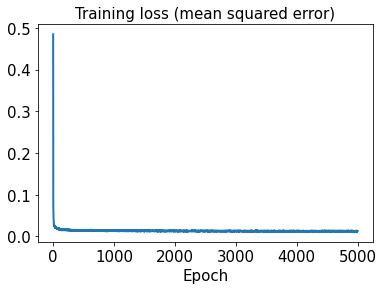

In [27]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

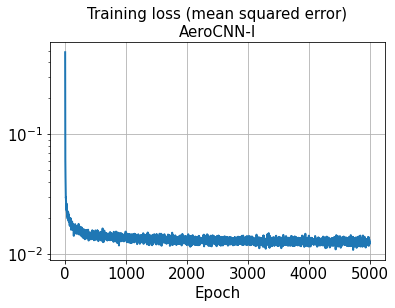

In [73]:
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-I', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

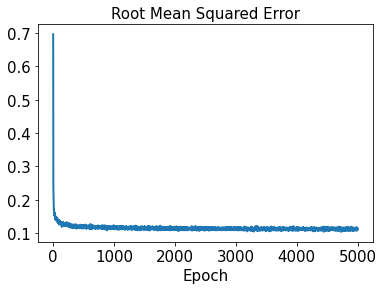

In [29]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [30]:
test_results = model.evaluate([x_train,aa_train])

47/47 [==============================] - 0s 2ms/step - loss: 8.1909e-06 - rmse: 0.0000e+00


In [31]:
decoded_train = model.predict([x_train,aa_train])

47/47 [==============================] - 0s 2ms/step


In [32]:
decoded_test = model.predict([x_test, aa_test])

20/20 [==============================] - 0s 2ms/step


In [33]:
error_train_abs = np.abs(decoded_train - y_train)

In [34]:
error_test_abs = np.abs(decoded_test - y_test)

In [35]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [36]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [37]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [38]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [39]:
decoded_train.shape

(1488, 2, 1)

In [40]:
os.chdir("D:\\TrainedModels\\20220929")
model.save('AeroCNN-I_2FClayer_Dropout0.5.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [41]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.2269213770430459


In [42]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.25125405481193047


In [43]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.22590711238328173


In [44]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.2529096456262121


In [45]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.25004554862991607


In [46]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.27924459980454047


In [47]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.47389012571845074, 0.5770991678815639, 0.7500439442755544, 1.7249756094974322, 0.25767204873526867, 0.06324933745255151, 0.02384658521635851, 0.05125226699011715, 0.037744067513805914, 0.031362466877513616, 0.05921019311891673, 0.04558559182929216, 0.06860246195142894, 0.07843931198329722, 0.07486361479196577, 0.08081733505846282, 0.38857671987003, 0.480763252299359, 0.5751264335811116, 0.7211116601141391, 1.4581886955550143, 0.3601413130753376, 0.08470721426888247, 0.07894196423588497, 0.03785908907577893, 0.05450029462232475, 0.06218274813400535, 0.09964883272877627, 0.013281528490214458, 0.09992946464471932, 0.03623672923427858, 0.07527520132029689, 0.5606148240102566, 0.5976560282180498, 0.5747813989938745, 0.7698387184076102, 1.3668668333925398, 1.2763777886734102, 0.2603732177455341, 0.1373365930415168, 0.09188800869606296, 0.06956004645015879, 0.10065697017108922, 0.11537153060937884, 0.13993215270630663, 0.3470084166021255, 0.059158962983074624, 0.05222559554693985, 0.585778

In [48]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.5616581037637934, 0.5676015432146555, 0.5667322945117047, 0.7436354975740793, 1.26628813685997, 1.6199074315790762, 0.3061616600906876, 0.18636684100979, 0.14717389505544798, 0.10504602965694011, 0.4402265447863075, 0.11020593720081004, 0.17557590068607423, 0.31996484233408984, 0.05698531380222607, 0.32797091234799436, 0.3952064432319324, 0.43153281979799096, 0.48172493701223823, 0.590436043992246, 2.479968189527449, 0.035651314177014566, 0.09482760010976232, 0.08898281294201071, 0.04398348390168587, 0.06861663306335825, 0.09829293086503366, 0.1177631812367114, 0.10904216920739247, 0.049066911601012876, 0.3022659375367939, 0.2528618493966672, 0.5469559508886981, 0.5868692818038838, 0.5626460436804045, 0.7417676958168836, 1.2495510235161436, 1.7743820367889693, 0.3582460509531095, 0.20501995177813942, 0.14826538113743912, 0.07101450360572173, 0.6802309218057483, 0.2961763206807994, 0.09576575338314652, 0.1896517555182178, 0.034469904590431366, 0.0965335000024455, 0.468938616556078, 0

In [49]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.4743546125970066, 0.5775199691708331, 0.7504870120936695, 1.759178063818062, 0.24915842456534312, 0.05111188813207634, 0.020254949492393735, 0.04244171092222398, 0.015043559685816839, 0.01448520549009248, 0.032082545905100165, 0.011947790176351822, 0.05819481760943036, 0.04399046683789033, 0.043691037068122086, 0.03269371008710507, 0.3887605445680901, 0.4811172601554165, 0.5754181854595689, 0.721409809336264, 1.4758824737989114, 0.3587634095415389, 0.07798728906690777, 0.07566002324690622, 0.029567568327244127, 0.05143584564993249, 0.06132914880820717, 0.09550400401976067, 0.009203215607947637, 0.09523292737445171, 0.0163771300147265, 0.06968030023599314, 0.568749757314275, 0.6027065849090851, 0.5762490199183429, 0.770011116131697, 1.367708064309259, 1.2874674740527077, 0.25344766136674673, 0.1326038727401635, 0.08265376633506814, 0.06736838579465083, 0.10093771542213244, 0.09217519894002203, 0.127013692644851, 0.3540971507747605, 0.05875031397076069, 0.05126183496899978, 0.59775594

In [50]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.019514597811255394, 0.3258762705191401, 0.642801184712767, 0.8946901792554085, 0.6137099991754917, 0.7809891671317625, 0.38684728875322777, 1.0403671815245803, 1.2665735753366743, 0.9163398845027004, 1.3558379575827453, 0.9906737890643289, 0.6588234605140018, 0.9025299673368861, 0.728511582702009, 0.6596850879485467, 0.2801250053193266, 0.03867490925080149, 0.36245737663887423, 0.6324242955142673, 0.8346804650492885, 0.43073563354039374, 0.6390257324933517, 0.6222583417368104, 0.7179264730566929, 0.5045349819769305, 0.2381193681920326, 0.5159099849737837, 0.1277371985598829, 0.3575747809237657, 0.28727268725594324, 0.21242910520127167, 0.39009668831666555, 0.3886049037409158, 0.2611356965942838, 0.7060084748989667, 1.288410161159623, 0.7628887952470986, 1.2749609551653005, 1.1137784322758246, 1.2092966591351055, 0.2874969926018889, 0.0693233844816415, 0.3267171353189629, 0.2507581739458604, 0.27211189582496537, 0.06255266335296253, 0.0590717496110146, 0.39322271692311384, 0.36609603

In [51]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.5691799110267941, 0.5717235353490988, 0.5680355513148837, 0.7438604792736461, 1.267161679456457, 1.642031975114698, 0.29998991405276254, 0.18256382184886855, 0.1419873316039082, 0.10425091275464743, 0.44613701071614303, 0.09675343630565676, 0.16989264085196096, 0.322521389063249, 0.057092913067997034, 0.3376916599364787, 0.39541353843518545, 0.43168983211907463, 0.4815651209387079, 0.588959885145892, 3.410511148510518, 0.01571815398767764, 0.08734265019978871, 0.08537846226284904, 0.036026806382732424, 0.06387035307059397, 0.09250583381890039, 0.11180703135024697, 0.10712033169764418, 0.048493944439206446, 0.3071885861078402, 0.2388251944173286, 0.5545615760605762, 0.5897605521280824, 0.5637721907925095, 0.7415861027323833, 1.2490675177590171, 1.80351214773794, 0.3526619647443062, 0.20128734446256039, 0.14248341023845765, 0.06589359597989153, 0.6846175697942515, 0.2876626037180655, 0.08671151934034059, 0.1927556084018, 0.03529560838476781, 0.09276696914552775, 0.4751323099853724, 0.

In [52]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.3909768416549841, 0.3952282445998361, 0.2415600559398671, 0.6577467071637596, 1.1795882977739456, 0.853758175102268, 1.285425950232082, 1.0938992686769848, 0.9480772700696943, 0.2080934655500422, 0.17095522668376897, 0.2498794371905879, 0.23649829871816858, 0.29419394935188886, 0.05607671899511057, 0.2557957943759322, 0.06306314324008452, 0.2584966023218165, 0.5661668828163634, 0.8271874647606225, 1.0284215473964824, 0.4094005838058016, 0.9463536732714963, 0.8923326067642975, 1.0357947814900086, 1.0485281222093008, 1.259775129049792, 1.1057351441958256, 0.40119605526374436, 0.089680291903101, 0.14190447776185536, 0.31907334787768465, 0.3841616962116348, 0.4553016624840398, 0.14176852162795037, 0.8208967588376013, 1.3039602957203038, 0.7814641604605915, 1.3200504160091973, 1.2202312903287227, 1.3804313950906248, 0.5589863748771519, 0.08456805280795303, 0.42899928740129145, 0.17970256350722838, 0.14937738865812888, 0.026102564355243572, 0.11992303362750324, 0.23261976941637422, 0.0244

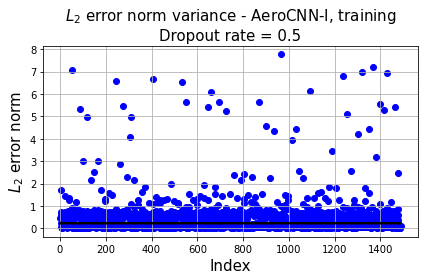

In [53]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, training\nDropout rate = %.1f' % dropout_rate, fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

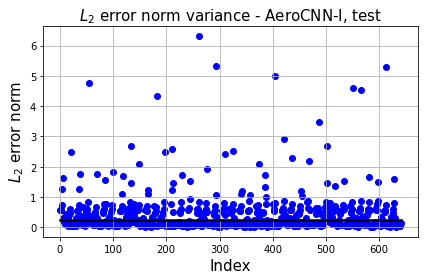

In [54]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

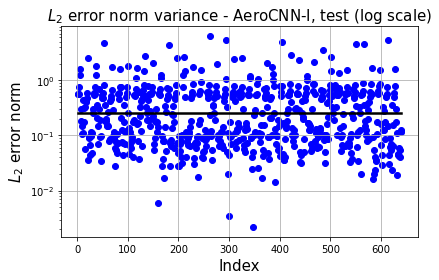

In [55]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

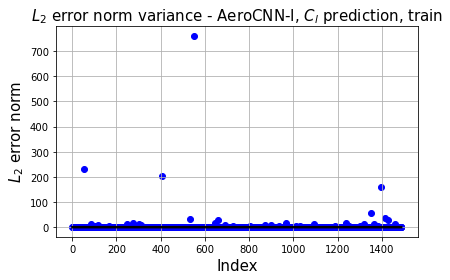

In [56]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

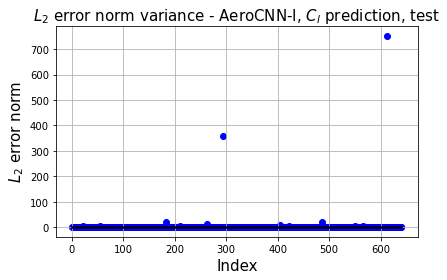

In [57]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

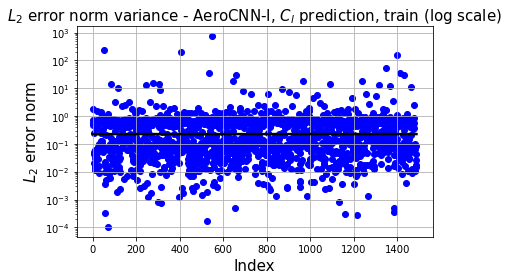

In [58]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

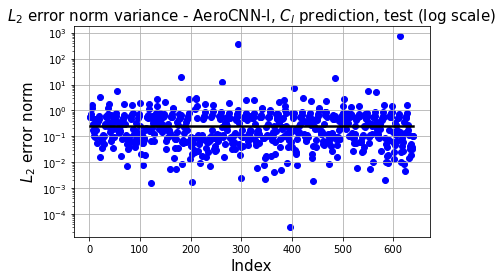

In [59]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

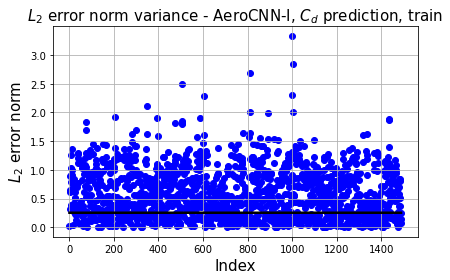

In [60]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

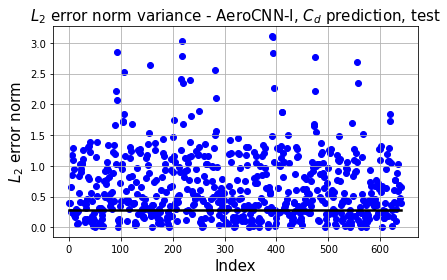

In [61]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

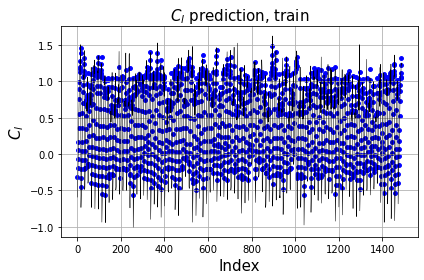

In [62]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

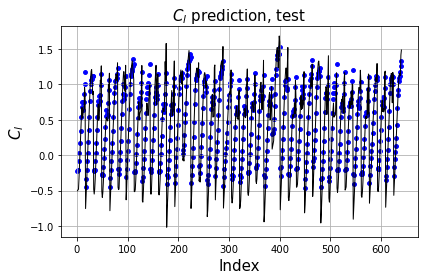

In [63]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

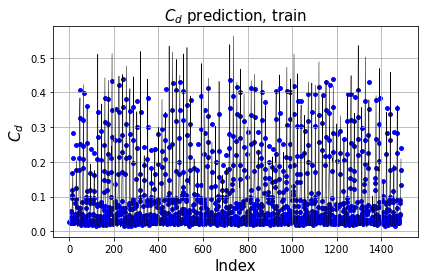

In [64]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

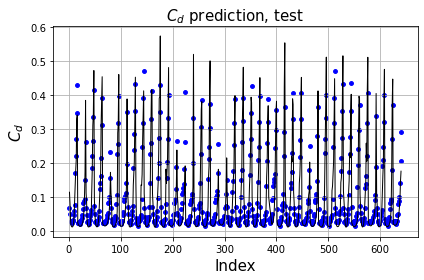

In [65]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

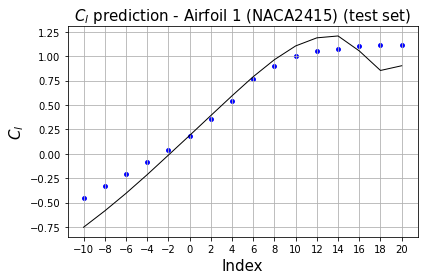

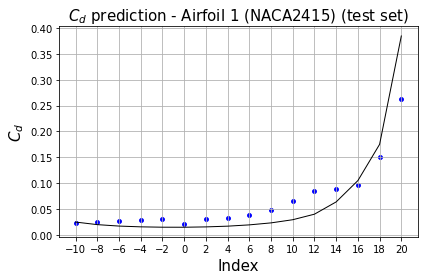

In [66]:
airfoiltest1_predict = decoded_test[16*1:16*2]

airfoiltest1_cl=y_test[16*1:16*2,0,:]
airfoiltest1_cd=y_test[16*1:16*2,1,:]

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 1 (%s) (test set)' % (str(geo_test[1*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 1 (%s) (test set)' % (str(geo_test[1*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [67]:
decoded_test.shape

(640, 2, 1)

In [68]:
np.unique(geo_test)

array([b'NACA000834', b'NACA0010', b'NACA001034', b'NACA001264',
       b'NACA0024', b'NACA1408', b'NACA2408', b'NACA2411', b'NACA2415',
       b'NACA2418', b'NACA4412', b'NACA4415', b'NACA4421', b'NACA63010a',
       b'NACA63012a', b'NACA631412', b'NACA63210', b'NACA632415',
       b'NACA632615', b'NACA634221', b'NACA64008a', b'NACA64108',
       b'NACA64110', b'NACA6412', b'NACA64206', b'NACA64209',
       b'NACA64a210', b'NACA651412', b'NACA661212', b'NACA663218',
       b'RAE100', b'RAE101', b'RAE102', b'RAE2822', b'RAE5212',
       b'RAE5214', b'RAE69CK', b'RAF19', b'RAF31', b'RAF48'], dtype='|S32')

In [69]:
geo_test.shape[0]/16

40.0

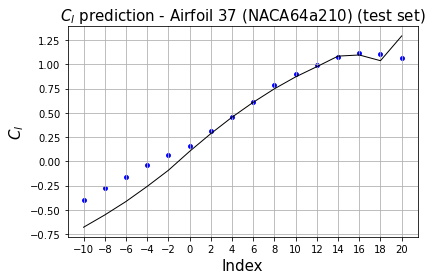

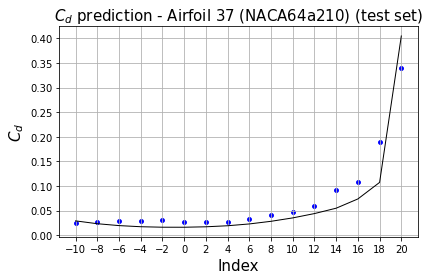

In [70]:
airfoiltest37_predict = decoded_test[16*36:16*37]

airfoiltest37_cl=y_test[16*36:16*37,0,:]
airfoiltest37_cd=y_test[16*36:16*37,1,:]

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (test set)' % (str(geo_test[37*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (test set)' % (str(geo_test[37*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

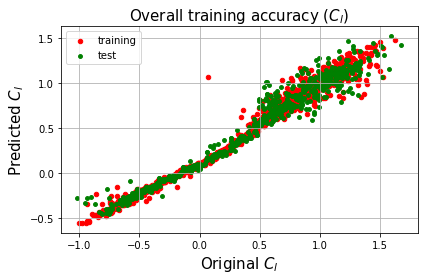

In [71]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

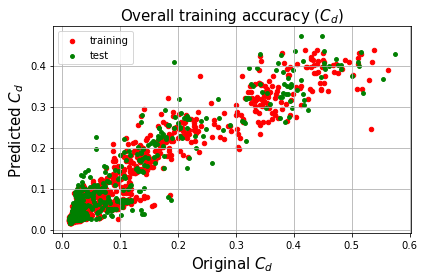

In [72]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()